# HIDDEN MARKOV NEURAL NETWORK: MNIST example- Evolving classifier

We study the performance of HMNN on an evolving in time labeller, which artificially generated from the MNIST dataset.

## Import libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn import preprocessing


import pickle

import gzip

import numpy as np
import random

## Data processing

In [2]:
# Set the seed to guarantee reproducibility
seed_number = 123

random.seed(seed_number)
torch.manual_seed(seed_number)
np.random.seed(seed_number)

The files "train-labels-idx1-ubyte.gz" and "train-images-idx3-ubyte.gz" can be downloaded from:

- http://yann.lecun.com/exdb/mnist/

In [3]:
def load_mnist():
    """Load MNIST data from `path`"""
    labels_path = 'train-labels-idx1-ubyte.gz'
    images_path = 'train-images-idx3-ubyte.gz'
        
    with gzip.open(labels_path, 'rb') as lbpath:
        lbpath.read(8)
        buffer = lbpath.read()
        labels = np.frombuffer(buffer, dtype=np.uint8)

    with gzip.open(images_path, 'rb') as imgpath:
        imgpath.read(16)
        buffer = imgpath.read()
        images = np.frombuffer(buffer, 
                               dtype=np.uint8).reshape(
            len(labels), 784).astype(np.float64)
 
    return images, labels

def mnist_preprocessing(x, y, sample_N = 300000, test_ratio = 0.3):

    x = np.float32(x) / 126.
    #np.save("mnist_preprocessed_data", x)
    y = np.int32(y)
    #np.save("mnist_preprocessed_target", y)
    idx = np.random.choice(x.shape[0], sample_N)
    x = x[idx]
    y = y[idx]

    tr_idx, te_idx = train_test_split(np.arange(sample_N), test_size = test_ratio)
    tr_x, te_x = x[tr_idx], x[te_idx]
    tr_y, te_y = y[tr_idx], y[te_idx]

    return tr_x,te_x,tr_y,te_y

In [4]:
x,y = load_mnist()
tr_x, te_x, tr_y, te_y = mnist_preprocessing(x, y)

In [5]:
tr_x = tr_x[0:200000,:]
tr_y = tr_y[0:200000]

In [6]:
np.size(tr_y, 0)

200000

## Evolving classifier

### Probability evolution

Probability $f_t$ of choosing classifier $\mathcal{C}_1$.

In [71]:
%matplotlib inline

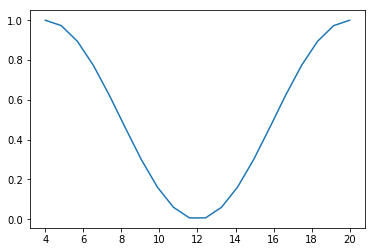

In [72]:
import matplotlib.pyplot as plt

p_grid = 0.5*np.sin(np.pi/8*np.linspace(4, 20, 20))+0.5

plt.plot(np.linspace(4, 20, 20), p_grid)
plt.show()

### Classifier

Set up the dataset by changing the labels according to probabilit $f_t,1-f_t$ and $\mathcal{C}_1,\mathcal{C}_2$ 

In [73]:
class_1 = np.linspace(0, 9, 10).astype(int)
class_2 = (class_1+1)%10

In [74]:
total_size_tr  = 200000
total_size_val = 200000

tr_x_tr = np.copy(tr_x[0:total_size_tr, :])
tr_y_tr = np.copy(tr_y[0:total_size_tr])

tr_x_val = np.copy(tr_x[total_size_tr:total_size_tr+total_size_val, :])
tr_y_val = np.copy(tr_y[total_size_tr:total_size_tr+total_size_val])

In [75]:
trace_tr = (tr_y_tr==0)
trace_val = (tr_y_val==0)

In [76]:

task_size_tr = 10000
task_size_val = 10000

for t in range(0,20):
    j = 0 
    
    trace_class_tr  = list()
    trace_class_val = list()
    for trace_index in range(0,10):
        trace_class_tr.append(tr_y_tr[t*task_size_tr:(t+1)*task_size_tr] == trace_index)
        trace_class_val.append(tr_y_val[t*task_size_val:(t+1)*task_size_val] == trace_index)
        
    for i in class_2:
        coins_tr  = np.random.uniform(0, 1, np.sum(trace_class_tr[j])) 
        coins_val = np.random.uniform(0, 1, np.sum(trace_class_val[j])) 

        tr_y_tr[t*task_size_tr:(t+1)*task_size_tr][trace_class_tr[j]]   = (coins_tr>= p_grid[t])*int(i) + (coins_tr< p_grid[t])*int(j)
        tr_y_val[t*task_size_val:(t+1)*task_size_val][trace_class_val[j]] = (coins_val>= p_grid[t])*int(i) + (coins_val< p_grid[t])*int(j)
        
        j = j +1
        
        

In [77]:
tr_x_te = tr_x_val
tr_y_te = tr_y_val

The new label is  4
  
The image is 


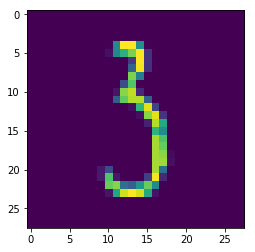

In [78]:
t=10
image = 10
plt.imshow(tr_x_tr[t*task_size_tr:(t+1)*task_size_tr,:][image].reshape(28,28))

print("The new label is ", tr_y_tr[t*task_size_tr:(t+1)*task_size_tr][image])
print("  ")
print("The image is ")

Check the expected $f_t$ on training and validation. We can simply count the number of labels that are zero.

In [15]:
p_est_tr = np.zeros(20)
p_est_val = np.zeros(20)

for t in range(0,20):
#     print(t)
    p_est_tr[t] = np.sum(tr_y_tr[t*task_size_tr:(t+1)*task_size_tr][trace_tr[range(t*task_size_tr,(t+1)*task_size_tr)]]==0)/np.sum(trace_tr[range(t*task_size_tr,(t+1)*task_size_tr)])
    p_est_val[t] = np.sum(tr_y_val[t*task_size_val:(t+1)*task_size_val][trace_val[range(t*task_size_val,(t+1)*task_size_val)]]==0)/np.sum(trace_val[range(t*task_size_val,(t+1)*task_size_val)])

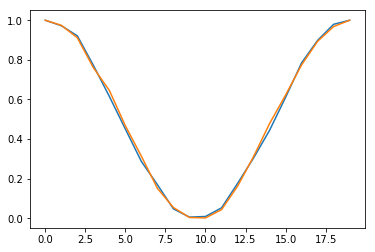

In [16]:
plt.plot(p_est_tr)
plt.plot(p_est_val)
plt.show()

## HMNN

### Set the hyper parameters for the training

In [17]:
# The sample size
sample_size    = 10000
# The minibatch size
minibatch_size = 128
# The number of epochs

epocs          = 10 #Optimal value 600
# This parameter if use to retrain on part of the previous data. 
# If sliding = sample_size then we move to a new set of data.
sliding = 10000
# Number of Sequential training we want to do minus 1
T = 20

###########################################################
# Set the network structure
# Depth
L = 4
# Structure of the hidden units
architecture = np.array([784, 100, 100, 10])

# Kernel parameter of the HMNN
alpha_k = 0.5
sigma_k = np.exp(-2)
c       = np.exp(5)
pi      = 0.5

# Mixture weight for the variational dropconnect
p       = 0.8

# Learning rate
lr_c = 1e-3

# Size of the Monte Carlo sample
mc_c = 1

### Training procedure

In [20]:
%run -i BayesianNetwork.py

In [21]:
# Loss function
loss_function = torch.nn.CrossEntropyLoss(reduction = 'sum')


HMMNET = torchHHMnet(architecture, alpha_k, sigma_k, c, pi, p, loss_function, sample_size, minibatch_size, epocs, T, sliding, workers = 4)

HMMNET.forward_pass(tr_x_tr, tr_y_tr, tr_x_val, tr_y_val, lr_c, mc_c)

Time  1
Epoch  1
Prior score  1205.0180272106022  and Data score  307.17129347656595
Performance on the validation set  0.2682
Epoch  2
Prior score  1204.2640388742107  and Data score  261.8445468340303
Performance on the validation set  0.4269
Epoch  3
Prior score  1200.2080928589664  and Data score  186.4203915226673
Performance on the validation set  0.5994
Epoch  4
Prior score  1198.248612241787  and Data score  137.69963363389778
Performance on the validation set  0.7455
Epoch  5
Prior score  1195.3286683423614  and Data score  116.56392161282395
Performance on the validation set  0.8088
Epoch  6
Prior score  1193.3048971802607  and Data score  100.67363123299857
Performance on the validation set  0.8414
Epoch  7
Prior score  1191.1402851865591  and Data score  86.80620847757145
Performance on the validation set  0.8763
Epoch  8
Prior score  1188.6418506311777  and Data score  79.95270274632493
Performance on the validation set  0.8767
Epoch  9
Prior score  1186.7099664834911  and

Prior score  106.99748574848476  and Data score  114.48504406412077
Performance on the validation set  0.6733
Epoch  9
Prior score  107.2836255842212  and Data score  113.62089854205794
Performance on the validation set  0.6743
Epoch  10
Prior score  107.02297416817531  and Data score  113.02385056109459
Performance on the validation set  0.6733
Time  15
Epoch  1
Prior score  105.22685157217849  and Data score  127.67564738203565
Performance on the validation set  0.4946
Epoch  2
Prior score  105.5537515288454  and Data score  126.99741539173432
Performance on the validation set  0.4731
Epoch  3
Prior score  105.41199983378719  and Data score  126.11270746650763
Performance on the validation set  0.4602
Epoch  4
Prior score  105.65949035472684  and Data score  125.03421710127972
Performance on the validation set  0.4937
Epoch  5
Prior score  105.6688715545756  and Data score  125.68976796173166
Performance on the validation set  0.4908
Epoch  6
Prior score  105.76461158328064  and Data

### Validation and Test procedure

Divide in validation and test

In [53]:
task_size_val = 10000

tr_x_test = np.zeros((int(task_size_val/2)*19, 784))
tr_y_test = np.zeros((int(task_size_val/2)*19))

tr_x_val = np.zeros((int(task_size_val/2)*19, 784))
tr_y_val = np.zeros((int(task_size_val/2)*19))

for t in range(0, 19):
#     print(t)
    tr_x_val[(t)*int(task_size_val/2):(t+1)*int(task_size_val/2),:]  = tr_x_te[(t)*task_size_val:(t)*task_size_val+int(task_size_val/2),:]
    tr_x_test[(t)*int(task_size_val/2):(t+1)*int(task_size_val/2),:] = tr_x_te[(t)*task_size_val+int(task_size_val/2):(t+1)*task_size_val,:]
    
    tr_y_val[(t)*int(task_size_val/2):(t+1)*int(task_size_val/2)]  = tr_y_te[(t)*task_size_val:(t)*task_size_val+int(task_size_val/2)]
    tr_y_test[(t)*int(task_size_val/2):(t+1)*int(task_size_val/2)] = tr_y_te[(t)*task_size_val+int(task_size_val/2):(t+1)*task_size_val]   

Validation plot

In [54]:
val_performance = np.zeros(19)
task_size_val = 5000
for t in range(0,19):
    y_predicted     = np.zeros(len(tr_y_val[t*task_size_val:(t+1)*task_size_val]))

    output           = HMMNET.model_list[t+1].performance( torch.tensor( tr_x_val[t*task_size_val:(t+1)*task_size_val,:], dtype = torch.float64 ) )
    output_softmax   = F.softmax(output, dim=1)

    y_predicted = np.array( range(0, 10) )[ np.argmax( output_softmax.data.numpy(), 1 ) ]

    val_performance[t] = sum(tr_y_val[t*task_size_val:(t+1)*task_size_val] == y_predicted)/len(tr_y_val[t*task_size_val:(t+1)*task_size_val])

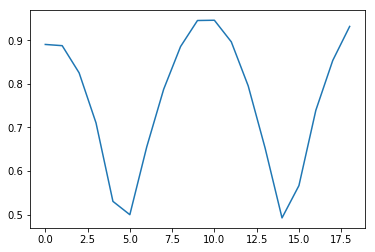

In [55]:
plt.plot(val_performance)
plt.show()

Test performance (mean over time of the accuracy)

In [62]:
test_performance = np.zeros(19)
task_size_test = 5000

for t in range(0,19):
    y_predictestd     = np.zeros(len(tr_y_test[t*task_size_test:(t+1)*task_size_test]))

    output           = HMMNET.model_list[t+1].performance( torch.tensor( tr_x_test[t*task_size_test:(t+1)*task_size_test,:], dtype = torch.float64 ) )
    output_softmax   = F.softmax(output, dim=1)

    y_predicted = np.array( range(0, 10) )[ np.argmax( output_softmax.data.numpy(), 1 ) ]

    test_performance[t] = sum(tr_y_test[t*task_size_test:(t+1)*task_size_test] == y_predicted)/len(tr_y_test[t*task_size_test:(t+1)*task_size_test])

print("Performance on the test set ", np.mean(test_performance))

Performance on the test set  0.7634526315789474


## Bayes by Backprop on the whole dataset

### Set the hyper parameters for the training

In [63]:
# The sample size
sample_size    = 200000
# The minibatch size
minibatch_size = 128
# The number of epochs

epocs          = 10 #Optimal value 600
# This parameter if use to retrain on part of the previous data. 
# If sliding = sample_size then we move to a new set of data.
sliding = 0
# Number of Sequential training we want to do
T = 1

###########################################################
# Set the network structure
# Depth
L = 4
# Structure of the hidden units
architecture = np.array([784, 100, 100, 10])

# Kernel parameter of the HMNN
alpha_k = 0.0
sigma_k = np.exp(-2)
c       = np.exp(5)
pi      = 0.5

# Mixture weight for the variational dropconnect
p       = 0.8

# Learning rate
lr_c = 1e-3

# Size of the Monte Carlo sample
mc_c = 1

### Training procedure

In [64]:
# Loss function
loss_function = torch.nn.CrossEntropyLoss(reduction = 'sum')


HMMNET_nokernel = torchHHMnet(architecture, alpha_k, sigma_k, c, pi, p, loss_function, sample_size, minibatch_size, epocs, T, sliding, workers = 4)

HMMNET_nokernel.forward_pass(tr_x_tr, tr_y_tr, tr_x_val, tr_y_val, lr_c, 2)

Time  1
Epoch  1
Prior score  48.72051565238155  and Data score  209.38947853206454
Performance on the validation set  0.45952631578947367
Epoch  2
Prior score  49.790262395937354  and Data score  147.5162805841129
Performance on the validation set  0.4680526315789474
Epoch  3
Prior score  50.43563401566258  and Data score  136.85363282615475
Performance on the validation set  0.47349473684210525
Epoch  4
Prior score  50.93388740238188  and Data score  130.9782446113977
Performance on the validation set  0.47646315789473687
Epoch  5
Prior score  51.336655723190226  and Data score  127.06270379403013
Performance on the validation set  0.4803368421052632
Epoch  6
Prior score  51.65277612688113  and Data score  124.54391040238542
Performance on the validation set  0.4806947368421053
Epoch  7
Prior score  51.90755295474439  and Data score  122.80944259151262
Performance on the validation set  0.4815684210526316
Epoch  8
Prior score  52.11655741529687  and Data score  121.30338877087361
Per

Test performance (mean over time of the accuracy)

In [67]:
test_performance = np.zeros(19)
task_size_test = 5000

for t in range(0,1):
    y_predictestd     = np.zeros(len(tr_y_test[t*task_size_test:(t+1)*task_size_test]))

    output           = HMMNET_nokernel.model_list[t+1].performance( torch.tensor( tr_x_test, dtype = torch.float64 ) )
    output_softmax   = F.softmax(output, dim=1)

    y_predicted = np.array( range(0, 10) )[ np.argmax( output_softmax.data.numpy(), 1 ) ]

    test_performance[t] = sum(tr_y_test == y_predicted)/len(tr_y_test[t*task_size_test:(t+1)*task_size_test])

print("Performance on the test set ", np.mean(test_performance))

Performance on the test set  0.48048421052631585
